# Aster Centering Analysis - Day 1
***
<i> Dmitrief, Turlier, De Labbey, Badaoui </i> </br>
<i> ENS - Active Matter  Workshop - Feb 22 </i>

In this notebook, we use Cytosim Analysis to analyze a Simulation where an Aster autonomously moves to the center.

## Imports

In [1]:
#Classic Import

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
import sys
import os 

#Cytolysis Import
from cytolysis import cytosim_analysis as ana


from aster import Aster_set
from tweezer import Tweezer_set
import methods
#from methods import distance, colin, total_force, total_individual_forces, tweezer_distance


In [2]:
#PARAMETERS

frame_step = 1 #1 frame of simulation corresponds to 1s

#PATH

from pathlib import Path
current_path = str(Path().absolute()) 
path_simu = current_path  + '/simu'

## <u> Hands on Cytosim </u>

This part has been largely inspired by documentation and tutorials available on [Cytosim's repository](https://gitlab.com/f-nedelec/cytosim/-/tree/master/doc "Cytosim").

### Executables

Cytosim has three main executables:

*   `sim` reads instructions from a config file, usually `config.cym` and runs the simulation.
*   `play` displays an existing simulation. `play live` runs the simulation and displays it simultaneously.
*   `report` exports data to the terminal or to text files.

To simplify the tutorial, we have precompiled `sim`, `play` and `report` on each station for a 2-dimensional space, and renamed these executables `cytosim-sim`, `cytosim-play` and `cytosim-report`, which may be called anywhere in your workspace.

### Configuration 

An example of config file :

```
set simul system
{
    time_step = 0.1
    viscosity = 0.001
    steric = 1, 200
}

set space cell
{
    shape = circle
}

new cell
{
    radius = 10
}

set bead ball
{
    steric = 1
    confine = inside, 500
}

new 1 bead ball
{
    radius = 1
    position = 1 0
}

run 500 system
{
    nb_frames = 500
}

```

[Config files](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/config.md "Config file documentation") contain a sequence of [commands](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/commands.md "Commands documentations"). The three main commands, that you can see above are :  

* `set` to define an object category
* `new` to create objects
* `run` to perform simulation steps

### Parameters

In Cytosim, [units](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/units.md "Units") are μm, pN, s.

#### Steric interations

One has to set whether steric interactions between objects will be considered or not. The first argument after steric is a boolean (0 for no interactions, 1 for interactions). The second parameter is the steric stiffness. Repulsion is indeed implemented by a [repulsive quadratic potential](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/steric.md "steric").

Confinement works in a similar way: the first argument defines the confinement mode: `inside` confines the center, `all_inside` confines the whole object, `on` to confine on the border... The second parameter is the confinement stiffness.

#### Spaces

One has to give the shape and dimensions. A list of available shapes can be found [here](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/spaces.md "Spaces").


#### Objects
Various objects have lots of different parameters. Beads are among the simplest. In the following, more complex objects such as fibers or motor will be considered.

###  Your first simulation

#### System and cell
```
set simul system
{
    time_step = 0.001
    viscosity = 0.01
}

set space cell
{
    shape = sphere
}

new cell
{
    radius = 10
}
```

#### Microtubules

```
set fiber microtubule
{
    rigidity = 20
    segmentation = 0.5
    confine = inside, 500
    
    activity = classic
    growing_speed    = 0.5
    growing_force    = 1.67
    shrinking_speed  = -0.85
    catastrophe_rate = 0.01
    catastrophe_rate_stalled = 0.04
    rescue_rate      = 0.064
    min_length       = 0.5
    persistent       = 0
 
    display = ( line_width = 4; )
}

new 1 fiber microtubule
{
    length = 10
    plus_end = grow
}

run system
{
    nb_steps = 50000
    nb_frames = 100
}
```

**Q0. Follow these steps to run your first simulation**

* Go to `/simu/example_microtubules/`


* Run `cytosim-play live config.cym` in the folder and see the simulation in live.

* Run `cytosim-sim config.cym` in the folder. This generates the .cmo result files. You can then play them with the command `cytosim-play`

#### Comments 
Microtubules polymerize until a castrophe happens.   

Stochastic attachment and detachment of monomers are not taken into account in Cytosim. Instead, polymerization is modeled as a constant expansion of the fiber, at the speed `growing_speed`.  

The growth of microtubule generates forces, when stuck against a boundary for example. In return, the growth speed diminishes: `growing_force` is the force for which the polymerization speed reaches zero. It is also the typical force a microtubule exerts because of polymerization.  

Microtubules are deleted when shorter than `min_length`.  

The `catastrophe_rate` is the rate for a free microtubule. It is higher when microtubules are stalled, which corresponds to a microtubule stuck against a boundary and the parameter `catastrophe_rate_stalled`.

Microtubules are deleted when shorter than `min_length`. 

### Aster

An aster is an organizer: it links the core, an undeformable solid, to microtubules. Each microtubule is nucleated from the center and linked to the core by two links to prevent it from pivoting. The first stifness is the one at the center.  

Create a config file with the information below in `/simu/example_aster/` directory and run it in live with the `cytosim-play live` command.

(**changed time step to make Aster formation faster - Magid**)

``` 
set simul system
{
    time_step = 0.1
    viscosity = 0.01
}

set space cell
{
    shape = sphere
}

new cell
{
    radius = 10
}

set fiber microtubule
{
    rigidity = 20
    segmentation = 0.5
    confine = inside, 500

    activity = classic
    growing_speed    = 0.5
    growing_force    = 1.67
    shrinking_speed  = -0.85
    catastrophe_rate = 0.01
    catastrophe_rate_stalled = 0.04
    rescue_rate      = 0.064
    min_length       = 0.5
    persistent       = 1

    display = ( line_width = 4; )
}

set solid centrosome
{
    display = ( style=3; color=blue; )
    confine = inside, 100, cell
}

set aster core
{
    stiffness = 1000, 500
}

new core
{
    solid = centrosome
    radius = 0.5
    point1 = center, 0.5
    fibers = 50, microtubule, ( length = 2; plus_end = green;)
    position = -6,0
}

run system
{
    nb_steps = 10000
    nb_frames = 200
}

``` 

#### Photo of an Aster from a Simulation

<img src="img/aster.png" alt="Aster" width="700px">

## <u>  Aster centering </u>

In this tutorial, we will keep investigating on several mechanisms for aster centerin :

* Pushing of microtubules on the membrane
* Bulk pulling of dyneins carrying vesicles along microtubules
* Cortical pulling of dyneins attached to transmembrane complexes


#### Aster Centration - Pushing

<video controls src="img/pushing.mp4" style="width: 300px;"  />

#### Aster Centration - Vesicule Pulling

<video controls src="img/pulling.mp4" style="width: 300px;"  />

As said before we deal with microtubules that can polymerize until a catastrophe happens :  

Fibers keep growing at a `growing_speed`, which generates a force. When they grow against a boundary the growth speed diminishes : `growing_force` is the force for which the polymerization speed reaches zero.  

## <u> Pushing </u>


### <i> <u> First Part - Position </u> </i>
<i>First We will check the Position of The Aster</i>.

**Q1. Run the simulation with the config file in `/simu/pushing/example_pushing` by using the `cytosim-sim` command:**

* `cytosim-sim config.cym `

**Q2. Report the characteristic of the Aster with the `report`:**

* ` cytosim-report aster:force > force.txt`
* ` cytosim-report aster:links > links.txt`


`force.txt` contains all the information about the position (X,Y) and the force for applied to the aster through time.

`links.txt` contains all the information about the position (X,Y) and the force for each link through time.

**Q3. Check the files consistency and use the `cytosim_analysis` package to analyze the report files (see below).**

*NB : You should get a Pandas DataFrame summarizing all the important quantitites.*

In [38]:
def cytosim_analysis_function(path_in):
    
    # REPORT FILES
    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in + "/links.txt" #Links for the Aster
    #Config
    config_file = path_in + "/config.cym" #Config File

    # DICTIONNARY
    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    # CREATE SIMULATION INSTANCE
    simul = ana.Simulation(solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)

    # ANALYSIS FUNCTION DECLARATION
    analyzer={"distance": methods.distance, 
              "total_force":methods.total_force} 

    # ANALYSIS
    simul.make_analysis(frame_analyzer=analyzer)
    
    
    return simul

In [39]:
folder_test = '/pushing/example_pushing'

simul = cytosim_analysis_function(path_simu + folder_test)
df_analysis = simul.frames_analysis

distance_aster = df_analysis['distance']

In [40]:
df_analysis

id  distance         total_force
0      0  6.000000   [0.0019, -0.0001]
1      1  5.915133   [0.9472, -8.9775]
2      2  5.902674   [-2.1289, 1.7288]
3      3  5.697998    [0.1675, -2.632]
4      4  5.287838  [-3.4826, -1.8695]
..   ...       ...                 ...
96    96  2.733596  [77.7045, 28.8669]
97    97  2.735816  [72.3899, 23.6957]
98    98  2.644654  [79.1142, 23.8636]
99    99  2.607286  [79.2474, 34.0623]
100  100  2.555319  [75.5062, 27.9173]

[101 rows x 3 columns]

**Q4. Is the Aster Centering ?**

* **A. Plot the distance to the center with respect to the time and check the stability of it.**


* **B. You can help yourself with the `cytosim-play` command on Cytosim to understand why the aster might be centering or not .**

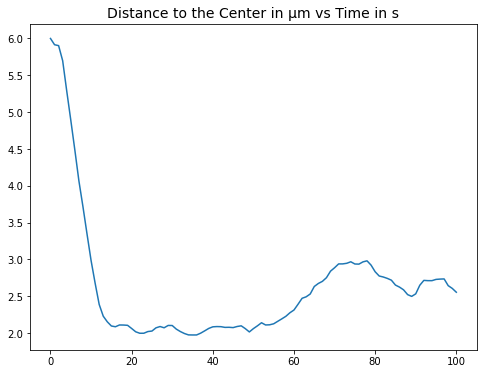

In [41]:
#PLOTS
#Centration of The Aster
plt.figure(figsize =(8,6))
plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")
plt.title('Distance to the Center in µm vs Time in s',size =14)
plt.show()

* **C. If it is not centering, what do you suggest to correct it ?**

You can tweak the parameters in the `example_pushing_centering` directory and restart the simulation !
Replot the position of the aster as function of time and compare.

Try in particular to tweak the microtubule dynamics parameters (`catastrophe_rate` and `catastrophe_rate_stalled`):  

``` 
set fiber microtubule
{
    rigidity = 20
    segmentation = 0.5
    confine = inside, 100
    activity = classic

    growing_speed            = 1
    shrinking_speed          = -3
    catastrophe_rate         = 0.1
    catastrophe_rate_stalled = 0.2
    rescue_rate              = 1
    growing_force            = 0.15
    min_length 				 = 0.5
	max_length		         = 20

    persistent = 1

    display = { line_width=5; }
}

```

<i> <u> Solution </u></i>  

In [42]:
folder_test = '/pushing/example_pushing_centering'

simul = cytosim_analysis_function(path_simu + folder_test)
df_analysis = simul.frames_analysis
distance_aster = df_analysis['distance']

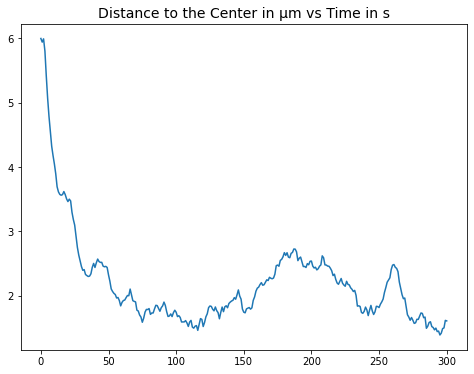

In [8]:
#PLOTS
#Centration of The Aster
plt.figure(figsize =(8,6))
plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")
plt.title('Distance to the Center in µm vs Time in s',size =14)
plt.show()

### <i> <u> Second Part - Force </u></i>
<i>One way to quantify te stability of the Aster Positionning is to measure the force with respect to the position, to conclude whether or not the position is a stable fixed point.
</i>

**Q5. Make a plot of the force as function of time along x and y-axis, using the same simulation as before**

#### Solution: force along the x axis

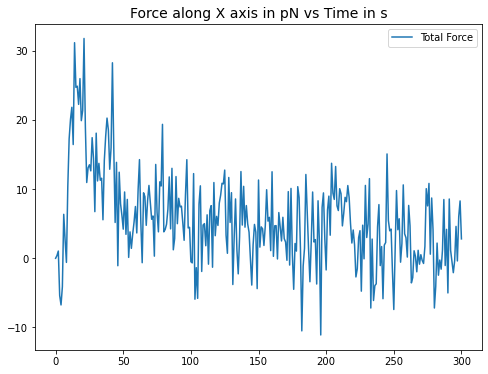

In [9]:
# Force along x axis
plt.figure(figsize =(8,6))
plt.plot(df_analysis["id"]*frame_step,np.array(df_analysis['total_force'].to_list())[:,0],label="Total Force")
plt.title('Force along X axis in pN vs Time in s',size=14)
plt.legend()
plt.show()

#### Force along the y axis

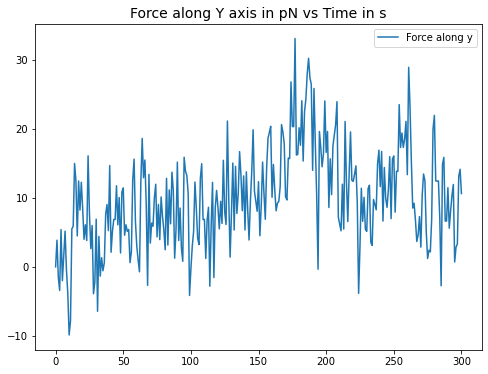

In [10]:
# Force along y axis
plt.figure(figsize =(8,6))
plt.plot(df_analysis["id"]*frame_step,np.array(df_analysis['total_force'].to_list())[:,1],label="Force along y")
plt.title('Force along Y axis in pN vs Time in s',size=14)
plt.legend()
plt.show()

#### There are a lot of fluctuations and this might be hard to interpret, how to solve that issue ?  

### <i> <u> Third Part - Tweezer </u> </i>

In experiments, one could use an optical tweezer to measure the force depending on the position. In Cytosim, a tweezer can also be implemented as a space. Here, we will use it to fix arbitrarily the position of the aster. To do so, one has to confine the centrosome core in the tweezer.

```
set space tweezer
{
    shape = tweezer
}

new tweezer
{
    center = ( 3 0 )
}

set solid centrosome
{
    display = ( style=3; color=blue; )
    confine = inside, 100, tweezer
}
```


<i> Thanks to the tweezer, we will try to plot the force on the aster as function of the position of the aster. </i>

**Q6. Run the simulation with the config file in the folder `/simu/pushing/example_tweezer` with the `cytosim-sim` command**

**You can check that the Aster is indeed constrained to a defined position  with `cytosim-play`.**

**Q7. Report the position and force of the aster. Report the position of the tweezer with the following report command and compare with the position of the aster:**  

* `cytosim-report space:tweezer > tweezer.txt`  


**Q8. Use the `cytosim_analysis` package to analyze the report files and Plot interesting quantities.**


In [30]:
def cytosim_analysis_function_tweezer(path_in):
    
    # REPORT FILES
    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster
    #Tweezer
    space_file = path_in + "/tweezer.txt" #Optical Tweezer Properties
    #Config
    config_file = path_in + "/config.cym" #Config File

    # DICTIONNARY
    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}
    #Space
    spaces = {"position": space_file}
    space_opts = {"type": "space", "set": Tweezer_set}
    
    # RUN SIMUL
    simul = ana.Simulation(space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)
    
    # ANALYSIS FUNCTION DECLARATION
    analyzer={"distance": methods.distance, 
              "position": methods.position, 
              "total_force": methods.total_force,
              "tweezer_distance": methods.tweezer_distance}
    
    # ANALYSIS
    simul.make_analysis(frame_analyzer=analyzer)
    return simul 

In [31]:
simul_tweezer = cytosim_analysis_function_tweezer(path_simu + '/pushing/example_tweezer')
df_analysis_tweezer=simul_tweezer.frames_analysis


In [32]:
df_analysis_tweezer

id  distance           position          total_force  tweezer_distance
0      0  6.000000        [-6.0, 0.0]     [0.0016, 0.0006]               3.0
1      1  2.999301   [2.9993, -0.002]    [-0.7855, -4.116]               3.0
2      2  3.006803  [3.0068, -0.0043]   [-0.2279, -1.8588]               3.0
3      3  2.990206  [2.9902, -0.0061]    [-5.7301, 9.2288]               3.0
4      4  3.009701   [3.0097, 0.0021]     [5.9576, 0.1056]               3.0
..   ...       ...                ...                  ...               ...
296  296  2.997801  [2.9978, -0.0022]   [-14.0739, 1.4823]               3.0
297  297  2.978936  [2.9789, -0.0147]   [-18.9519, 2.5972]               3.0
298  298  2.984709  [2.9847, -0.0074]   [-22.0451, 0.8652]               3.0
299  299  2.994300  [2.9943, -0.0005]  [-22.2921, -6.3209]               3.0
300  300  2.986303  [2.9863, -0.0039]   [-24.0386, 1.4636]               3.0

[301 rows x 5 columns]

**Q9. From the previous data, compute and plot the time-evolution and mean force and position of the aster along the X and Y axis and compare their values.**

In [25]:
# PLOT

plt.figure(figsize=(12,10))

ax1  = plt.subplot(211)
ax1.plot(df_analysis_tweezer["id"]*frame_step, np.array(df_analysis_tweezer['distance'].to_list()))
ax1.set_title('Position of the Aster in µm vs Time in s', size=14)

ax2 = plt.subplot(223)
ax2.plot(df_analysis_tweezer["id"]*frame_step, np.array(df_analysis_tweezer['total_force'].to_list())[:,0])
ax2.set_title('Total Force in pN - Along X axis vs Time in s', size=12)

ax3 = plt.subplot(224)
ax3.plot(df_analysis_tweezer["id"]*frame_step, np.array(df_analysis_tweezer['total_force'].to_list())[:,1])
ax3.set_title('Total Force in pN - Along Y axis vs Time in s', size=12)

plt.show()

Now that we have seen that we can contrain the position of the Aster with a Tweezer, we would like to probe preciseley the Force-Position relationship by computing the force for a wide range of position of the Tweezer.  

To do so, we will use configuration templates and work in the `pushing_tweezers` directory with template `config_tpl.cym`:


### <i> <u> Fourth Part - Pushing - Force vs Position </u> </i>

Now that we have seen that we can contrain the position of the Aster with a Tweezer, we would like to probe precisely the Force-Position relationship by computing the force for a wide range of positions of the Tweezer.  

To do so, we will use configuration templates and work in the directory `/simu/pushing/pushing_tweezer` with the template config file `config_.cym`:


``` 
[[ x = [-9 + i for i in range(19)]]]

set space tweezer
{
    shape = tweezer

}

new tweezer
{
    center = ( [[x]] 0 )
}
```

**Q9. In the folder `/simu/pushing/pushing_tweezer` follow these steps to generate config files, run simulations and report the aster, tweezer and link properties**  

* Generate the config files

  `../../../../python/run/preconfig.py config_.cym`
  

* Place in separated directories

  `mkdir config_files`  
  `mv config_00*.cym ./config_files`
  
* Get the executables here

  `cp ../../../../bin/sim .`  
    
* Run simulations

  `../../../../python/run/go_sim.py sim ./config_files/config_00*.cym njobs=10`
  
* Report aster and tweezer properties

 `../../../../python/look/scan.py 'cytosim-report aster:force > force.txt' run0*`  
 
 `../../../../python/look/scan.py 'cytosim-report aster:links > links.txt' run0*` 
 
 `../../../../python/look/scan.py 'cytosim-report space:tweezer > tweezer.txt' run0*`

**Q10. Loop over the runs and use `cytosim_analysis` to extract Force and Position**  

In [34]:
path_pushing = path_simu + '/pushing/pushing_tweezer/'
folders = os.listdir(path_pushing)[1:]
runs = [folder for folder in folders if folder.startswith("run0")]
print(runs)
simul_list = [cytosim_analysis_function_tweezer(path_pushing + run) for run in runs]
analysis_list = [simul.frames_analysis for simul in simul_list]

['run0012', 'run0002', 'run0013', 'run0014', 'run0011', 'run0000', 'run0007', 'run0003', 'run0005', 'run0017', 'run0004', 'run0008', 'run0009', 'run0016', 'run0006', 'run0001', 'run0018', 'run0015']


In [35]:
n_frames = analysis_list[0]['distance'].shape[0]
positions = [anali['position'][int(n_frames/2):] for anali in analysis_list]
forces = [anali['total_force'][int(n_frames/2):] for anali in analysis_list]

forces_X = [np.array([f[0] for f in force]) for force in forces]
pos_X = [np.array([p[0] for p in pos]) for pos in positions]

mean_pos_X = [np.mean(X) for X in pos_X]
mean_forces_X = [np.mean(force_X) for force_X in forces_X]
std_pos_X = [np.std(X) for X in pos_X]
std_forces_X = [np.std(force_X) for force_X in forces_X]


**Q11. Plot the Force along X as a function of the Assigned Position of the Tweezers**

In [36]:
#PLOT FORCE VS POSITION ALONG X

plt.figure(figsize = (10,8))

plt.scatter(mean_pos_X,mean_forces_X)
plt.errorbar(mean_pos_X, mean_forces_X, yerr=std_forces_X, xerr= std_pos_X, fmt='o')
plt.title("Force in pN vs Position in µm",size = 14)
plt.show()

### <i> <u> EXTRA - Fifth Part - Force vs Microtubule Length </u> </i>

We can also exploit the previous data trying to etablish the link between the Force and the Length of the Microtubule.  

**Q12. Report fibers properties with the following command in the folder `pushing_tweezers`**

 `../../../python/look/scan.py 'cytosim-report aster:links > links.txt' run0* njobs=10 `  

In [ ]:
def individual_force(frame):
    return frame.objects["solid"]["core"][0].fiber_forces[:,3:5]
 
def length_microtubule(frame):
    return frame.objects['fiber']['microtubule'][0].points[:,1]

def cytosim_analysis_function_tweezers_indiv(path_in):

    ## A PASSER DANS METHODS

    #Fibers
    fibers_file = path_in + "/fibers.txt" #Microtubule

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster

    #Tweezer
    space_file = path_in + "/tweezer.txt" #Optical Tweezer Properties 

    #Config
    config_file = path_in + "/config.cym" #Config File


    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    spaces = {"space": space_file}
    space_opts = {"set": Tweezer_set}

    microtubule_reports = {"points" : fibers_file}

    simul = ana.Simulation(fibers_report = {"microtubule" : microtubule_reports},
                           solid_report={"core": solids},
                           space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_options=solid_opts,
                           config = config_file,dim=2)   
    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force,
              "tweezer_distance":tweezer_distance,
              "length_microtubule":length_microtubule,
              "individual_force":individual_force}
    
    # ANALYSIS
    
    simul.make_analysis(frame_analyzer=analyzer)
    
    analysis=simul.frames_analysis
    
    return simul, analysis 


simul, df_analysis = cytosim_analysis_function_tweezers_indiv(path_simu + '/pushing/example_tweezer')

In [ ]:
analysis_list_size = []

path_pushing_size = path_simu + '/pushing/pushing_size_dependance/'

runs = np.sort(os.listdir(path_pushing_size))[1:]

for run in runs:
    print(run)
    analysis_list_size.append(cytosim_analysis_function_tweezers_indiv((path_pushing_size + run)))

**Q13. We also would like to plot the individual force as a function of the length of the microtubule**  

In [ ]:
radius_cell = list(range(3,13))
radius_cell

In [ ]:
analysis_list_size[0][1]['length_microtubule']

In [ ]:

force_length = []

for r, radius in enumerate(radius_cell):
    
    df_force_length_temp= pd.concat(
                [pd.DataFrame({'length' : analysis_list_size[r][1]['length_microtubule'][i], 
              'force' : np.linalg.norm(analysis_list_size[r][1]['individual_force'][i],axis=1)}) 
                 for i in analysis_list_size[r][1].index])

    df_force_length_temp = df_force_length_temp.join(pd.DataFrame({'radius' : [radius for i in range(len(df_force_length))]}))
    
    force_length.append(df_force_length_temp)
df_force_length = pd.concat(force_length)

df_force_length

In [ ]:
radius_aster = 0.5

df_force_length_filtered = df_force_length[df_force_length.length > (df_force_length.radius - radius_aster)]

In [ ]:
df_force_length_filtered 

In [ ]:
plt.figure(figsize = (12,10))

plt.scatter(df_force_length['length'].to_numpy(), df_force_length['force'].to_numpy())

plt.title("Force as a function of the length", size = 16)
plt.show()
